Multiclass classification with GPflow
--



The multiclass classification problem is a regression problem from an input $x \in {\cal X}$ to discrete labels $y\in {\cal Y}$ where ${\cal Y}$ is a discrete set of size $C$ bigger than 2 (for $C=2$ it is otherwise the more usual binary classification)

Labels are encoded in a one-hot fashion, that is if $C=4$ and $y=2$, we note $\bar{y} = [0,1,0,0]$

The generative model for this problem we consider is built of 
 * $C$ latent functions $\mathbf{f} = [f_1,...,f_C]$ with independent Gaussian Process prior
 * a determinisctic function building a discrete distribution $\pi(\mathbf{f}) = [\pi_1(f_1),...,\pi_C(f_C)]$ from the latents such that $\sum_c \pi_c(f_c) = 1$. 
 * a Discrete Likelihood $p(y|\mathbf{f}) = Discrete(y;\pi(\mathbf{f})) = \prod_c \pi_c(f_c)^{\bar{y}_c}$

A typical example of $\pi$ is the softmax function 

$$ \pi_c (f_c) \propto \exp( f_c)$$

Another convenient one is the Robust Max
$$
\pi_c(\mathbf{f}) = \begin{cases} 1 - \epsilon, & \mbox{if } c = \arg \max_c f_c \\
 \epsilon /(C-1), & \mbox{ otherwise} \end{cases}
$$





In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
#from gpflow.test_util import notebook_niter, is_continuous_integration
plt.style.use('ggplot')
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Generating data using a generative model

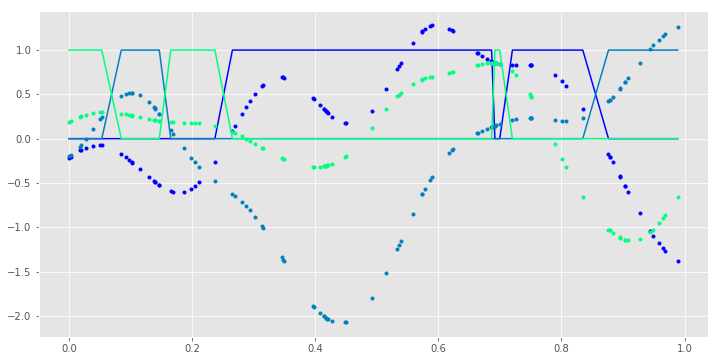

In [2]:
np.random.seed(1)
C, N = 3, 100
lsc = 0.01  # RBF kernel lengthscale 
jitter = 1e-6  # jitter to stabilize sampling

X = np.random.rand(N,1)
K = np.exp(-0.5*np.square(X - X.T)/lsc) + np.eye(N)*jitter  # RBF kernel
f = np.dot(np.linalg.cholesky(K), np.random.randn(N, C))
Y = np.argmax(f, 1).reshape(-1, 1).astype(float)  # Hard max observation
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y.astype(int).reshape(-1,)] = 1

plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))
colors = plt.cm.winter(np.linspace(0, 1, C))
for c in range(C):  
    plt.plot(X[order], f[order, c], '.', color=colors[c]);
    plt.plot(X[order], Y_hot[order, c], '-', color=colors[c])

## Inference


Inference here consists in computing the posterior distribution over the latent functions.
Different inference methods may be used
 * MCMC
 * Variational inference

These can be combined with the sparse variational GP approximation.

### Sparse Variational Gaussian approximation

In [3]:
m = gpflow.models.SVGP(
    X, Y, kern=gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01),
    likelihood=gpflow.likelihoods.MultiClass(3),
    Z=X[::5].copy(), num_latent=3, whiten=True, q_diag=True)

m.kern.kern_list[1].variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

Conditional: Inducing Feature - Kernel
False False
base conditional


,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/q_sqrt,Parameter,None,+ve,True,"(20, 3)",True,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ..."
SVGP/q_mu,Parameter,None,(none),True,"(20, 3)",True,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
SVGP/feature/Z,Parameter,None,(none),False,"(20, 1)",True,"[[0.417022004702574], [0.0923385947687978], [0..."
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,1.0


In [4]:
opt = gpflow.train.ScipyOptimizer(options={'maxls': 30,'ftol':1e-10})
for _ in range(2):
    opt.minimize(m, maxiter=1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 328.719618
  Number of iterations: 6
  Number of functions evaluations: 14
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.774953
  Number of iterations: 169
  Number of functions evaluations: 191


In [5]:
def plot(m):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    p, _ = m.predict_y(xx)
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    for i in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

Conditional: Inducing Feature - Kernel
False False
base conditional
Conditional: Inducing Feature - Kernel
False False
base conditional


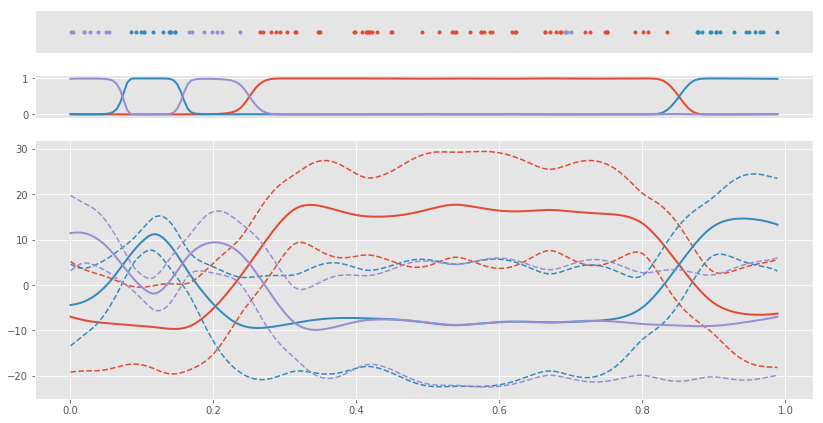

In [6]:
plot(m)